In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

from src.config import CargoBikeConfig, load_config
from src.osm_tags import build_tag_filter

from src import load_data as ld
import src.models.baseline as bl

import polars as pl
import geopolars as gpl
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
config = load_config(ROOT / "config" / "paper.yaml")

In [4]:
h3_df, service_time_df = ld.load_data(config,ROOT)
data = ld.process_data(h3_df, service_time_df)

# Boston predictions

In [5]:
data_boston = data.filter(pl.col('city') == 'Boston, USA')

In [6]:
data_boston.head()

h3,service_time,city,cluster,service_time_log,h3_count
str,f64,str,i64,f64,u32
"""892a3066c17fff…",363.0,"""Boston, USA""",0,5.894403,134
"""892a3066c17fff…",190.0,"""Boston, USA""",0,5.247024,134
"""892a3066c17fff…",131.0,"""Boston, USA""",0,4.875197,134
"""892a3066c17fff…",108.9,"""Boston, USA""",0,4.69043,134
"""892a3066c03fff…",49.0,"""Boston, USA""",0,3.89182,284


In [7]:
citywide_model = bl.CityWideAverageModel(data_boston)
citywide_samples = citywide_model.generate_samples()

In [18]:
kring_model = bl.KRingModel(data_boston, k=7)  
kring_samples = kring_model.generate_samples()

100%|██████████| 952/952 [00:02<00:00, 327.38it/s]


In [19]:
threering_model = bl.KRingModel(data_boston, k=3)  
threering_samples = threering_model.generate_samples()

100%|██████████| 952/952 [00:07<00:00, 119.52it/s]


In [9]:
empirical_samples = data_boston.groupby(['h3', 'cluster', 'city']).agg(pl.col('service_time').explode().alias('service_times'))
empirical_samples = empirical_samples.to_pandas()

/var/folders/66/24n_29v55jj2r9b1fvnxx43h0000gn/T/ipykernel_47257/332746594.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  empirical_samples = data_boston.groupby(['h3', 'cluster', 'city']).agg(pl.col('service_time').explode().alias('service_times'))


In [20]:
# Rename the samples column in each DataFrame to indicate the source
empirical_samples = empirical_samples.rename(columns={'service_times': 'empirical_samples'})
citywide_samples = citywide_samples.rename(columns={'samples': 'citywide_samples'})
kring_samples = kring_samples.rename(columns={'samples': 'kring_samples'})
threering_samples = threering_samples.rename(columns={'samples': 'threering_samples'})

# Merge the DataFrames on 'h3' and 'cluster'
merged_df = empirical_samples.merge(citywide_samples, on=['h3'], how='outer')
merged_df = merged_df.merge(kring_samples, on=['h3'], how='outer')
merged_df = merged_df.merge(threering_samples, on=['h3'], how='outer')

In [21]:
def concatenate_cluster_samples(df, column_name):
    """Concatenate all arrays for a given sample type within each cluster."""
    return np.concatenate(df[column_name].values)

# Group by 'cluster' and concatenate arrays in each sample column
grouped = merged_df.groupby('cluster')

clustered_samples = pd.DataFrame({
    'cluster': grouped.groups.keys(),
    'empirical_samples': grouped.apply(concatenate_cluster_samples, column_name='empirical_samples'),
    'citywide_samples': grouped.apply(concatenate_cluster_samples, column_name='citywide_samples'),
    'kring_samples': grouped.apply(concatenate_cluster_samples, column_name='kring_samples'),
    'threering_samples': grouped.apply(concatenate_cluster_samples, column_name='threering_samples')
}).reset_index(drop=True)


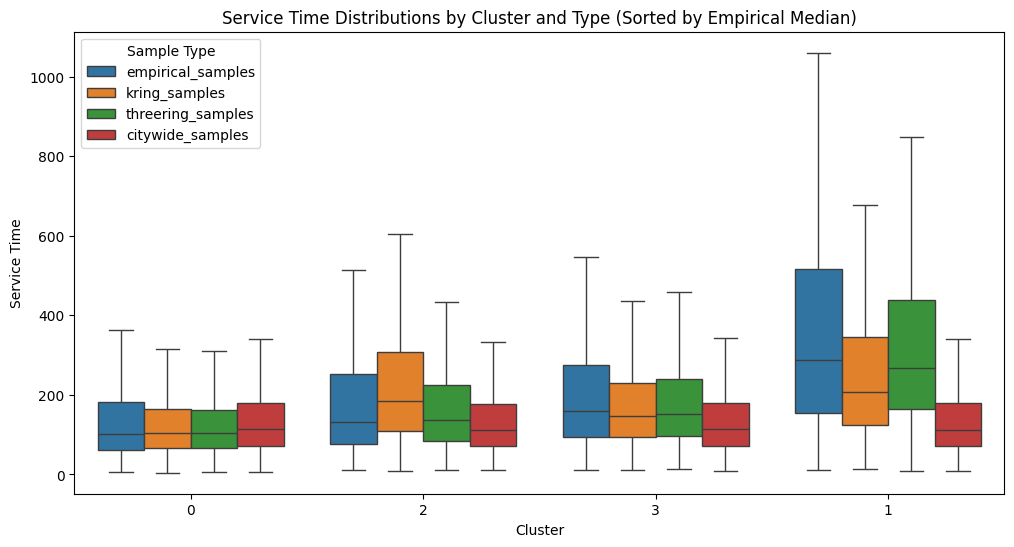

In [22]:
# Melt the DataFrame to transform it into a long format
melted_df = clustered_samples.melt(id_vars=['cluster'], 
                                   value_vars=['empirical_samples', 'citywide_samples', 'kring_samples', 'threering_samples'], 
                                   var_name='Type', value_name='service_time')

# Explode the service_time column to have individual values
melted_df = melted_df.explode('service_time')

# Calculate median service time for empirical samples in each cluster
empirical_medians = melted_df[melted_df['Type'] == 'empirical_samples'].groupby('cluster')['service_time'].median()

# Sort the clusters based on these median values
sorted_clusters = empirical_medians.sort_values().index.tolist()

# Reorder melted_df according to the sorted cluster order
melted_df['cluster'] = pd.Categorical(melted_df['cluster'], categories=sorted_clusters, ordered=True)
melted_df = melted_df.sort_values('cluster')

# Create the box plots in sorted order
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='service_time', hue='Type', data=melted_df, showfliers=False)
plt.title('Service Time Distributions by Cluster and Type (Sorted by Empirical Median)')
plt.xlabel('Cluster')
plt.ylabel('Service Time')
plt.legend(title='Sample Type')
plt.show()
